# Tabular data processing
> Data processing and EDA tools

In [ ]:
# default_exp tabular.data

In [ ]:
# export
from forgebox.imports import *
import scipy
from scipy.cluster import hierarchy as hc
from typing import List, Union

In [ ]:
# hide
# To be able to run the tests in the Notebook
!pip install -q ipytest pytest
from pathlib import Path
import ipytest
import sys
from IPython.utils.io import capture_output

ipytest.autoconfig()

root_dir = Path("..").resolve()
sys.path.append(str(root_dir / "test"))

## Load a dummy dataframe for testing

In [ ]:
# exportest
import pandas as pd
from pathlib import Path
try:
    df = pd.read_csv("./test/tabular/california_housing.csv")
except FileNotFoundError as e:
    df = pd.read_csv("../test/tabular/california_housing.csv")

## Dropping the columns with too much missing value

In [ ]:
# export
def no_missing_values(
    dataset: pd.DataFrame, missing_threshold: float = .6
) -> pd.DataFrame:
    """Find the features with a fraction of missing values above `missing_threshold`"""

    # Calculate the fraction of missing in each column
    missing_series = dataset.isnull().sum() / dataset.shape[0]
    missing_stats = pd.DataFrame(missing_series).rename(
        columns={'index': 'feature', 0: 'missing_fraction'})

    # Sort with highest number of missing values on top
    missing_stats = missing_stats.sort_values(
        'missing_fraction', ascending=False)
    display(missing_stats)

    # Find the columns with a missing percentage above the threshold
    record_missing = pd.DataFrame(
        missing_series[missing_series > missing_threshold])
    record_missing = record_missing.reset_index().rename(
        columns={'index': 'feature', 0: 'missing_fraction'})

    to_drop = list(record_missing['feature'])

    print(f'{len(to_drop)} features with greater than {missing_threshold*100:.1f}% missing values.')
    if to_drop:
        print('Removed features are:')
        for feat in to_drop:
            print(f"* {feat}")

    data = dataset.drop(columns=to_drop)
    return data

In [ ]:
# exportest

def test_no_missing_value_basic():
    from copy import deepcopy
    df2 = deepcopy(df).head(100)
    
    # create missing value manually
    for i,key in enumerate(df2):
        df2[key] = list(range(10*(i+1)))+[None,]*(9-i)*10
    new_df = no_missing_values(df2)
    assert list(new_df.columns) == list(df2.columns)[3:],\
        f"""
        Incorrect column filtering
        based on missing value: {list(new_df.columns)}"""

In [ ]:
df2 = no_missing_values(df)

,missing_fraction
MedInc,0.0
HouseAge,0.0
AveRooms,0.0
AveBedrms,0.0
Population,0.0
AveOccup,0.0
Latitude,0.0
Longitude,0.0


0 features with greater than 60.0% missing values.


## Plot histogram

In [ ]:
# export
def plot_hist(df: pd.DataFrame, feat2show: List[str]=None) -> None:
    """
    Plot histograms on columns feat2show
    default to plot all columns
    One historygram for each column
    """
    if feat2show is None: feat2show=df.columns
    nbr_plots = len(feat2show)
    ncols = 3
    if nbr_plots <= ncols: 
        raise RuntimeError('Please feat2show requires at least four features')
    else:
        nrows=(nbr_plots-1) // ncols +1

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, nrows * 4))
    for i, row in enumerate(axs):
        for j, ax in enumerate(row):
            idx = i*ncols+j
            if idx > nbr_plots-1: break
            f = feat2show[idx]
            ax.hist(df[f])
            ax.set_title(f)
    plt.show()

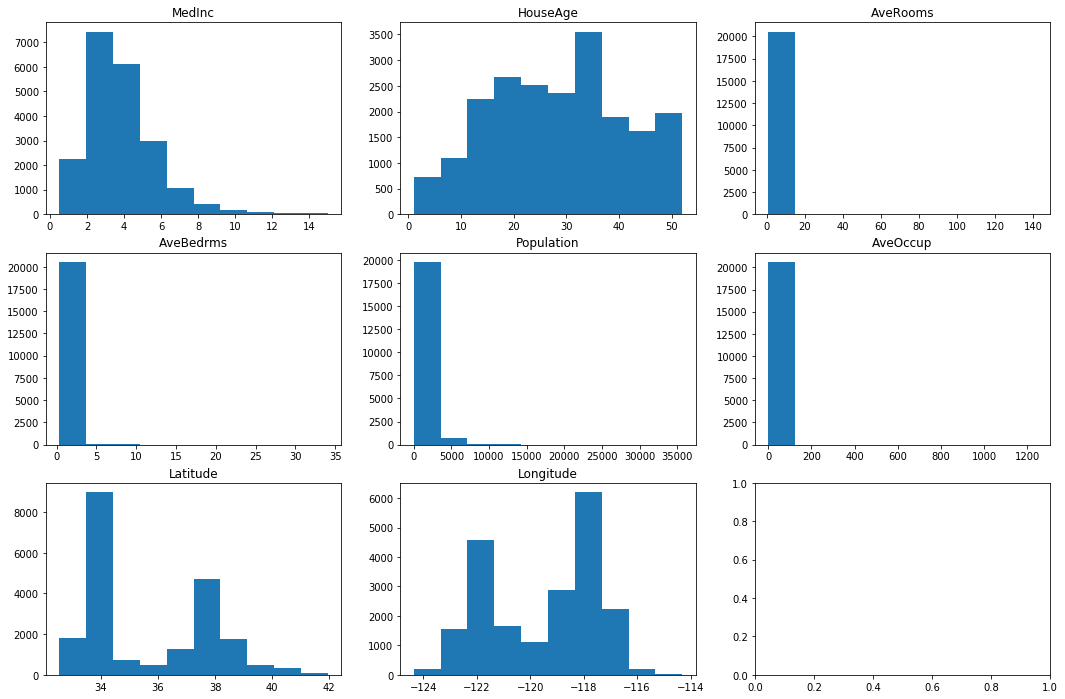

In [ ]:
plot_hist(df)

In [ ]:
# exportest
def test_plot_hist_run_through():
    """
    can plot_hist outpout an image
    """
    plot_hist(df.head(100))

## Compute and plot feature correlation matrix

In [ ]:
# export
def plot_feat_correlations(
    df: pd.DataFrame, 
    as_triangle: bool=True, 
    threshold: float=0.25,
    return_df: bool=False, 
) -> Union[None, pd.DataFrame]:
    """Plot the pearson correlation between features as a heatmap

    Parameters:
        df:          The dataframe whose feature correlations will be computed
        as_triangle: When True (default value) only show the lower part for higher readibility
        threshold:   All correlations whose absolute value is smaller than threshold will not be plotted. 
        return_df:   When True: return a dataframe with the full correlation matrix
        
    Return None or the correlation matrix depending on return_df
    """
    import scipy
    
    corr = df.corr()
    
    feats = corr.columns
    nfeats = len(feats) 
    non_num_feats = set(df.columns).difference(set(corr.columns))
    
    if non_num_feats:
        print(f"Following features are not numerical and are excluded from correlation matrix: {', '.join(non_num_feats)}")
    
    if nfeats >= 25:
        print(f"There are {nfeats} features. The correlation matrix may not be easily readable in a notebook.")
        print("You can visualize the matrix as an image by right clicking on it, 'open image in a new tab, and zoom.")

    corr2plot = corr.values.copy()
    corr2plot[corr.abs() < threshold] = 0

    if as_triangle:
        corr2plot = np.tril(corr2plot)
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(nfeats//2, nfeats//2))
    cmap = 'seismic'
    im = ax.imshow(corr2plot, cmap=cmap, vmin=-1, vmax=+1)

    # Display each feature as a tick with label
    ax.set_xticks(np.arange(len(feats)))
    ax.set_xticklabels(feats, fontsize='small')
    ax.set_yticks(np.arange(len(feats)))
    ax.set_yticklabels(feats, fontsize='small')
    
    # Rotate x-ticks.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Overlay each correlation values onto the heatmap
    for i in range(nfeats):
        for j in range(nfeats):
            text = ax.text(j, i, f"{corr2plot[i, j]:.2f}",
                           fontsize='x-small',
                           ha="center", va="center", color="w")

    new_line = '\n'
    title_l1 = 'Feature Correlation Matrix'
    title_l2 = f"Showing only correlations wider than +/-{threshold: .2f}"
    chart_title = f"{title_l1}{new_line}{title_l2}{f'{new_line}(Lower part only)' if as_triangle else ''}"
    ax.set_title(chart_title, fontsize='medium')
    
    fig.tight_layout()
    plt.show();
    
    if return_df: 
        return corr

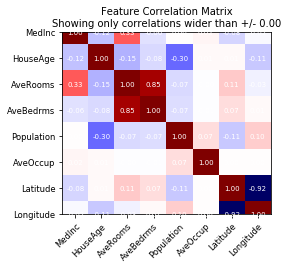

In [ ]:
plot_feat_correlations(df, as_triangle=False, threshold=0)

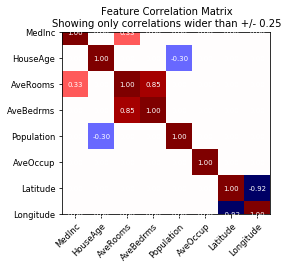

In [ ]:
plot_feat_correlations(df, as_triangle=False)

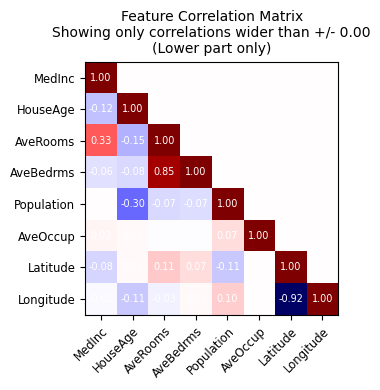

In [ ]:
plot_feat_correlations(df, threshold=0)

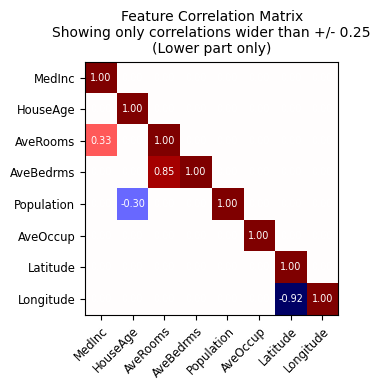

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
MedInc,1.000000,-0.119034,0.326895,-0.062040,0.004834,0.018766,-0.079809,-0.015176
HouseAge,-0.119034,1.000000,-0.153277,-0.077747,-0.296244,0.013191,0.011173,-0.108197
AveRooms,0.326895,-0.153277,1.000000,0.847621,-0.072213,-0.004852,0.106389,-0.027540


In [ ]:
corr = plot_feat_correlations(df,return_df=True)
corr.head(3)

In [ ]:
# exportest
# hide
def repeat_cols(df, n=2):
    df2 = df.copy()
    for feat in df2.columns:
        for i in range(1, n):
            df2[f"{feat}_{i}"] = df2[feat]
    return df2

def add_cat_feat(df, fname):
    import string
    s = string.ascii_lowercase
    vals = [s[i%20] for i in range(len(df))]
    df[fname] = vals

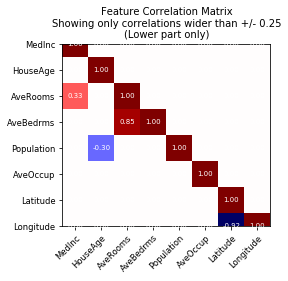

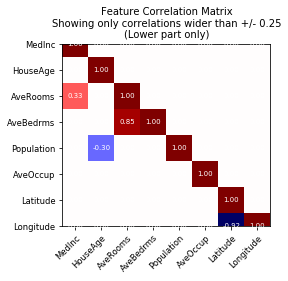

In [ ]:
# exportest
# hide
def test_return_df_true():
#   Setup
#   Run
    corr = plot_feat_correlations(df, return_df=True)
#   Verify
    assert isinstance(corr, pd.DataFrame), f"should return a dataframe and got {type(corr)}"

def test_return_df_false():
#   Setup    
#   Run
    corr = plot_feat_correlations(df, return_df=False)    
#   Verify
    assert corr is None, f"should return None and got {corr}"

test_return_df_true()
test_return_df_false()

Following features are not numerical and are excluded from correlation matrix: categorical_5, categorical_2, categorical_1, categorical_3, categorical_4


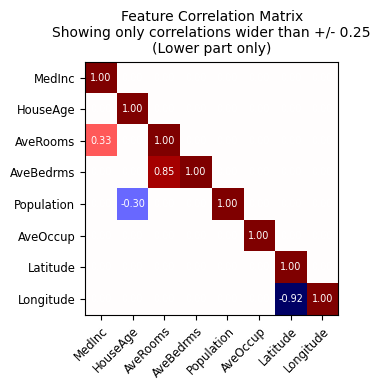

In [ ]:
# exportest
# hide
def test_non_numericals_dropped():
#    Setup
    df_test = df.copy()
    cat_fnames = [f"categorical_{i}" for i in range(1, 6)]
    for fname in cat_fnames:
        add_cat_feat(df_test, fname)
        
#   Run
    corr = plot_feat_correlations(df_test, return_df=True)
    
#   Verify
    assert corr.shape[1] == df_test.shape[1] - 5
    assert 'categorical' not in ' '.join(corr.columns)

test_non_numericals_dropped()

## Dendogram

In [ ]:
# export
def plot_feat_dendrogram(df: pd.DataFrame):
    """Plot the dendrograms of features based on spearman correlations

    Parameters:
        df: The dataframe whose feature correlations will be computed
        
    Return Nothing
    """    
    corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
    corr_condensed = hc.distance.squareform(1-corr)
    z = hc.linkage(corr_condensed, method='average')
    fig = plt.figure(figsize=(10,6))
    plt.title('Dendrogram of features based on spearman correlations', fontsize='medium')
    plt.xticks(fontsize='xx-small')
    hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size='small')
    plt.show()

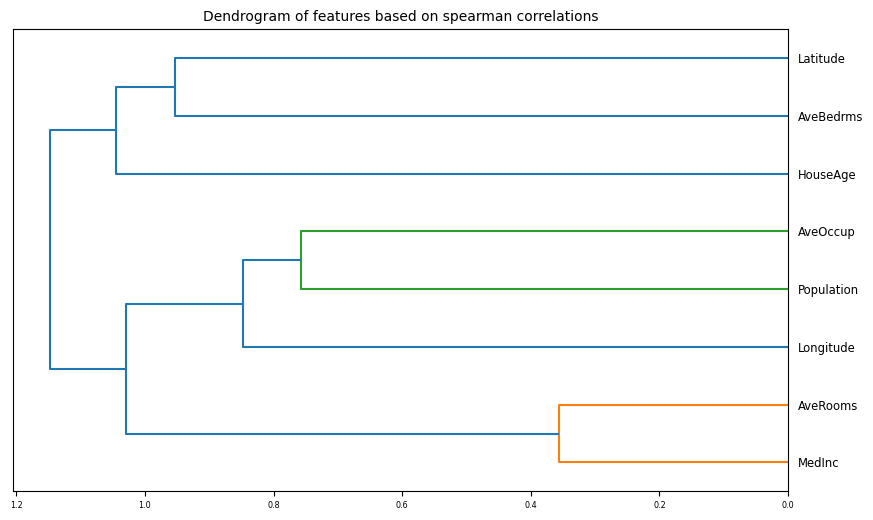

In [ ]:
plot_feat_dendrogram(df)

## Running all the test

,missing_fraction
MedInc,0.9
HouseAge,0.8
AveRooms,0.7
AveBedrms,0.6
Population,0.5
AveOccup,0.4
Latitude,0.3
Longitude,0.2


.

,missing_fraction
MedInc,0.9
HouseAge,0.8
AveRooms,0.7
AveBedrms,0.6
Population,0.5
AveOccup,0.4
Latitude,0.3
Longitude,0.2


.

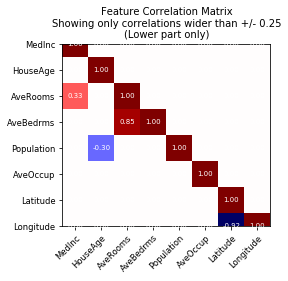

.

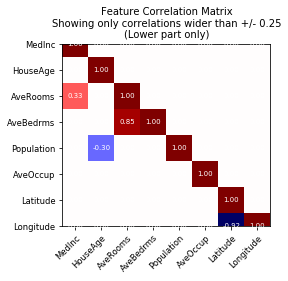

..                                                                                        [100%]
5 passed in 0.85s


In [ ]:
# hide
ipytest.run()